# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json
import logging

import optuna

import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

from bb_energy_prediction import models, data_utils, train, evaluate

c:\Users\thodo\miniconda3\envs\energy-prediction\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [2]:
no_dupl = False
if no_dupl:
    data_df = data_utils.get_data_df(data_path="../energy_data/no_dupl_data.pkl")
else:
    data_df = data_utils.get_data_df(data_path="../energy_data/data.pkl")

In [3]:
data_df.sample(10)

,bb,energy,program_name,bb_embeddings
518317,"[cmp %rdx %r9, jle 0x3e]",0.108170,variable_name,"[[2.359058, 0.7902903, 4.4327393, 1.9121364, 1..."
321936,"[movq %rbx, mov %rdx, mov %rax, mov %rbx %rcx,...",0.482440,swap,"[[0.85860157, 0.3787081, 2.0187519, -0.8874969..."
333129,"[sub $0x1 %rax, cmpb $0xa (%rax), jz 0x111]",0.048682,time,"[[1.4023652, 1.6352037, 2.4805996, 1.5314025, ..."
203598,"[movq %rbx, mov %rdx, mov %rax, mov %rbx %rcx,...",0.456746,ip,"[[0.85860157, 0.3787081, 2.0187519, -0.8874969..."
349055,"[cmpq $0x0, jz]",0.019925,variable_name,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
416720,"[cmp %rax %r12, jb]",0.108170,variable_name,"[[2.359058, 0.7902903, 4.4327393, 1.9121364, 1..."
38020,"[sub $0x1 %rax, cmpb $0xa (%rax), jz 0x111]",0.000141,find_biggest,"[[1.4023652, 1.6352037, 2.4805996, 1.5314025, ..."
212803,"[mov %rdx, mov %r15d %eax, movl %ebx, mov %rdx...",1.207112,ip,"[[2.5640976, -1.9068848, 0.81481344, -1.433819..."
331493,"[sub %r14 %rbx, mov %rbx %r13, add $0x18 %rsp,...",0.060675,time,"[[1.4023651, 1.635204, 2.480599, 1.5314032, -0..."
231996,"[movq %rdx, cmp %ebx, jz 0xbd]",0.293623,ip,"[[0.8586008, 0.37870914, 2.0187523, -0.8874969..."


In [4]:
if no_dupl:
    test_size = 0.15
else:
    test_size = 0.1

shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
test_size = int(test_size * len(shuffled_data_df))
test_df = shuffled_data_df[-test_size:]
train_val_df = shuffled_data_df[:-test_size]

print(f"Test data size: {len(test_df)}")

Test data size: 56165


# LSTM Model

## Optuna Trials

In [5]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-fixed-hidden"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/palmtee-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Max instructions", 20)
study.set_user_attr("Training-val data", len(train_val_df))
study.set_user_attr("lr_decay", 0.6)
study.set_user_attr("lr_decay_step", 9)

[I 2023-02-23 02:10:30,617] Using an existing study with name 'lstm-regression-fixed-hidden' instead of creating a new one.


Using an existing study with name 'lstm-regression-fixed-hidden' instead of creating a new one.


In [ ]:
def objective(trial):
    
    if no_dupl:
        lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
        hidden_size = trial.suggest_int("hidden_size", 4, 128)
        dense_size = trial.suggest_int("dense_size", 8, 256)
        smaller_dense_size = trial.suggest_int("smaller_dense_size", 4, 128)
        batch_size = trial.suggest_int("batch_size", 8, 64)
        lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
        dense_dropout = trial.suggest_float("dense_dropout", 0, 0.15)
        lr = trial.suggest_float("lr", 1e-5, 5e-2)
    else:
        lstm_layers = trial.suggest_int("lstm_layers", 1, 3)
        hidden_size = trial.suggest_int("hidden_size", 8, 128)
        dense_size = trial.suggest_int("dense_size", 16, 256)
        smaller_dense_size = trial.suggest_int("smaller_dense_size", 8, 64)
        batch_size = trial.suggest_int("batch_size", 128, 768)
        lr = trial.suggest_float("lr", 5e-4, 1e-2)
        lstm_dropout = trial.suggest_float("lstm_dropout", 0, 0.2)
        dense_dropout = trial.suggest_float("dense_dropout", 0, 0.2)

    data_loaders = data_utils.get_data_dict(
        data_df=train_val_df,
        enc_type="palmtree",
        mean=False,
        batch_size=batch_size,
        split=0.9
    )
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.LSTM_Regressor(
        embedding_size=embedding_size,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
        smaller_dense_size=smaller_dense_size,
        lstm_dropout=lstm_dropout,
        dense_dropout=dense_dropout,
    )
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]

study.optimize(objective, n_trials=100)

In [6]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_dropout,params_dense_size,params_hidden_size,params_lr,params_lstm_dropout,params_lstm_layers,params_smaller_dense_size,state
92,92,0.531542,2023-02-22 22:07:16.683996,2023-02-22 22:28:21.674831,0 days 00:21:04.990835,149,0.146933,175,84,0.000991,0.090846,2,37,COMPLETE
93,93,0.542557,2023-02-22 22:28:21.695833,2023-02-22 22:56:58.721420,0 days 00:28:37.025587,152,0.133188,178,84,0.001060,0.090301,2,37,COMPLETE
97,97,0.544004,2023-02-23 00:06:58.542783,2023-02-23 00:33:46.436055,0 days 00:26:47.893272,150,0.151967,164,82,0.000906,0.092482,2,37,COMPLETE
56,56,0.544162,2023-02-22 13:20:15.139750,2023-02-22 13:28:32.927793,0 days 00:08:17.788043,279,0.127935,123,60,0.001077,0.088357,2,51,COMPLETE
94,94,0.545879,2023-02-22 22:56:58.745923,2023-02-22 23:22:34.898669,0 days 00:25:36.152746,150,0.132972,172,84,0.000967,0.100007,2,38,COMPLETE
79,79,0.548191,2023-02-22 18:36:03.402774,2023-02-22 19:01:34.576282,0 days 00:25:31.173508,156,0.155562,156,92,0.000722,0.064621,2,41,COMPLETE
85,85,0.549782,2023-02-22 19:58:40.927291,2023-02-22 20:14:29.685674,0 days 00:15:48.758383,196,0.134641,176,99,0.001924,0.086390,2,49,COMPLETE
59,59,0.549893,2023-02-22 13:52:17.187458,2023-02-22 14:04:36.711049,0 days 00:12:19.523591,348,0.090364,84,81,0.000790,0.071662,2,56,COMPLETE
38,38,0.550018,2023-02-22 09:31:37.648245,2023-02-22 09:42:41.266050,0 days 00:11:03.617805,389,0.139760,72,45,0.001536,0.043094,2,38,COMPLETE
16,16,0.550399,2023-02-22 04:36:57.902343,2023-02-22 04:48:02.381571,0 days 00:11:04.479228,363,0.157109,233,48,0.000635,0.196569,2,8,COMPLETE


In [7]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size': 149, 'dense_dropout': 0.14693286925976803, 'dense_size': 175, 'hidden_size': 84, 'lr': 0.0009914340651946156, 'lstm_dropout': 0.09084570992229993, 'lstm_layers': 2, 'smaller_dense_size': 37}, achieving val RMSE: 0.5315424742776033


## Model Training

In [5]:
batch_size = 149

model_params = {
    "hidden_size": 84,
    "num_layers": 2,
    "dense_size": 175,
    "smaller_dense_size": 37,
    "lstm_dropout": 0.09,
    "dense_dropout": 0.15,
}

train_params = {
    "lr": 0.01,
    "epochs": 50,
    "early_stopping": True,
}

In [6]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/lstm_palmtree_models/base_model"

data_loaders = data_utils.get_data_dict(
    data_df=train_val_df,
    enc_type="palmtree",
    mean=False,
    batch_size=batch_size,
    split=0.9,
)

train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.LSTM_Regressor(embedding_size=embedding_size, **model_params)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/lstm_model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=True,
        **train_params,
    )

    if save:
        torch.save(train_results["model"].state_dict(), f"{exp_dir}/lstm_model")
        additional_attributes = {
            "model_params": model_params,
            "train_params": train_params,
            "loss": "RMSE",
            "batch_size": batch_size,
            "number of data": len(train_loader)*batch_size,
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

Epoch: 1/50, RMSE Train Loss: 0.59735, RMSE Val Loss: 0.60068
Epoch: 2/50, RMSE Train Loss: 0.58948, RMSE Val Loss: 0.58849
Epoch: 3/50, RMSE Train Loss: 0.5861, RMSE Val Loss: 0.57788
Epoch: 4/50, RMSE Train Loss: 0.58613, RMSE Val Loss: 0.58784
Epoch: 5/50, RMSE Train Loss: 0.58496, RMSE Val Loss: 0.61193
Epoch: 6/50, RMSE Train Loss: 0.58489, RMSE Val Loss: 0.58
Epoch: 7/50, RMSE Train Loss: 0.58674, RMSE Val Loss: 0.60546
Epoch: 8/50, RMSE Train Loss: 0.59004, RMSE Val Loss: 0.5896
Epoch: 9/50, RMSE Train Loss: 0.58801, RMSE Val Loss: 0.57697
Epoch: 10/50, RMSE Train Loss: 0.57975, RMSE Val Loss: 0.57994
Epoch: 11/50, RMSE Train Loss: 0.58043, RMSE Val Loss: 0.5771
Epoch: 12/50, RMSE Train Loss: 0.5806, RMSE Val Loss: 0.57662
Epoch: 13/50, RMSE Train Loss: 0.57911, RMSE Val Loss: 0.57915
Epoch: 14/50, RMSE Train Loss: 0.5802, RMSE Val Loss: 0.57778
Epoch: 15/50, RMSE Train Loss: 0.58017, RMSE Val Loss: 0.58113
Epoch: 16/50, RMSE Train Loss: 0.57839, RMSE Val Loss: 0.57884
Epoch: 17

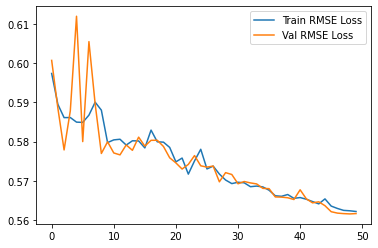

In [7]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

## Evaluation

In [8]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

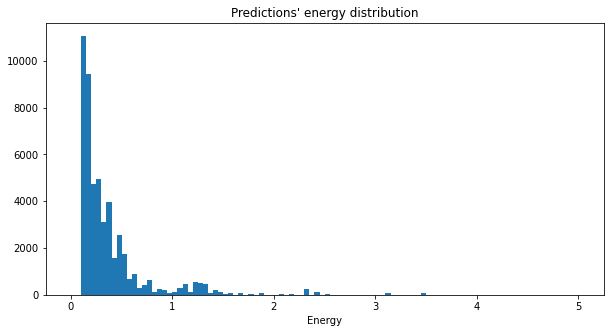

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

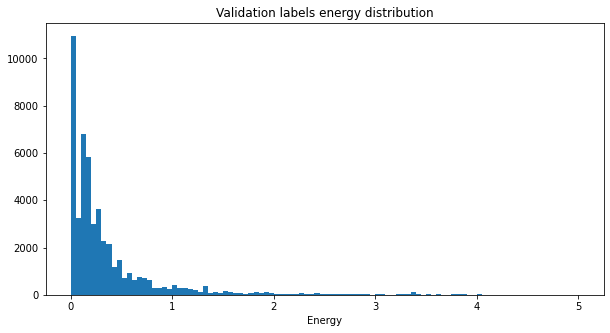

In [10]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [11]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.18773553401560195, Labels' std: 0.7033950418271452
MSE: 0.34
MAE: 0.26


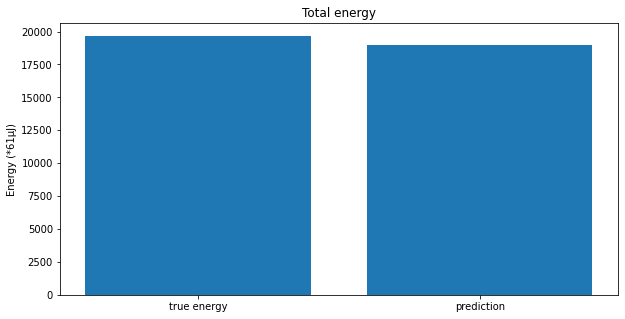

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

## Test programs prediction

In [13]:
test_embs = [emb.tolist() for emb in test_df.bb_embeddings.tolist()]
test_preds = evaluate.predict(model=model, test_bbs=test_embs)
true_energies = test_df.energy.values

In [14]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, test_preds), 3)
mae = round(mean_absolute_error(true_energies, test_preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.19081988415913198, Labels' std: 0.7239823427777025
MSE: 0.359
MAE: 0.263


# Simple Model

## Optuna Trials

In [37]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "simple-regression-study-no-duplicates"
storage_name = f"sqlite:////Users/thodo/Documents/sxoli/diplomatiki/optuna-studies/palmtee-regression-study.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")
study.set_user_attr("Loss", "RMSE")
study.set_user_attr("Max instructions", 25)
study.set_user_attr("Training-val data", len(train_val_df))

[I 2023-02-20 17:35:58,122] A new study created in RDB with name: simple-regression-study-no-duplicates


A new study created in RDB with name: simple-regression-study-no-duplicates
A new study created in RDB with name: simple-regression-study-no-duplicates
A new study created in RDB with name: simple-regression-study-no-duplicates


In [ ]:
def objective(trial):
    if no_dupl:
        num_layers = trial.suggest_int("dense_layers", 1, 3)
        dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
        batch_size = trial.suggest_int("batch_size", 8, 64)
        lr = trial.suggest_float("lr", 1e-5, 5e-2)
        dropout = trial.suggest_float("dropout", 0, 0.2)
        regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)
    else:
        num_layers = trial.suggest_int("dense_layers", 1, 6)
        dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
        batch_size = trial.suggest_int("batch_size", 128, 768)
        lr = trial.suggest_float("lr", 5e-4, 1e-2)
        dropout = trial.suggest_float("dropout", 0, 0.2)
        regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)

    data_loaders = data_utils.get_data_dict(
        data_df=data_df,
        enc_type="palmtree",
        mean=True,
        batch_size=batch_size,
        split=0.85
    )

    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    embedding_size = next(iter(train_loader))[0].shape[-1]

    model = models.Simple_Regressor(
        embedding_size=embedding_size,
        layers=dense_layers,
        dropout=dropout,
        regressor_dropout=regressor_dropout,
    )

    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=100)

In [41]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_0,params_dense_1,params_dense_2,params_dense_layers,params_dropout,params_lr,params_regressor_dropout,state
21,21,1.028067,2023-02-20 17:38:23.520061,2023-02-20 17:38:38.814061,0 days 00:00:15.294000,9,147,100.0,NaN,2,0.128239,0.003665,0.070508,COMPLETE
25,25,1.048125,2023-02-20 17:39:38.998537,2023-02-20 17:39:41.969131,0 days 00:00:02.970594,42,195,93.0,NaN,2,0.094140,0.008320,0.046991,COMPLETE
8,8,1.081606,2023-02-20 17:37:25.930309,2023-02-20 17:37:33.820837,0 days 00:00:07.890528,25,25,247.0,129.0,3,0.093078,0.036716,0.036602,COMPLETE
64,64,1.112874,2023-02-20 17:42:55.045257,2023-02-20 17:43:00.001257,0 days 00:00:04.956000,42,106,NaN,NaN,1,0.050925,0.030405,0.065509,COMPLETE
33,33,1.121179,2023-02-20 17:40:29.753430,2023-02-20 17:40:35.326126,0 days 00:00:05.572696,45,172,119.0,NaN,2,0.051554,0.015629,0.052171,COMPLETE
43,43,1.134420,2023-02-20 17:41:15.800524,2023-02-20 17:41:19.366023,0 days 00:00:03.565499,47,195,65.0,NaN,2,0.061834,0.015465,0.072825,COMPLETE
67,67,1.144105,2023-02-20 17:43:09.100172,2023-02-20 17:43:12.245008,0 days 00:00:03.144836,38,125,NaN,NaN,1,0.074234,0.027692,0.071769,COMPLETE
34,34,1.147167,2023-02-20 17:40:35.344625,2023-02-20 17:40:37.921625,0 days 00:00:02.577000,39,178,115.0,NaN,2,0.079120,0.015602,0.068800,COMPLETE
94,94,1.149503,2023-02-20 17:45:29.082828,2023-02-20 17:45:35.593181,0 days 00:00:06.510353,38,200,111.0,NaN,2,0.080498,0.035545,0.069777,COMPLETE
5,5,1.153466,2023-02-20 17:36:56.031091,2023-02-20 17:37:00.247690,0 days 00:00:04.216599,49,108,NaN,NaN,1,0.020049,0.034665,0.020358,COMPLETE


In [42]:
print(f"Best simple-regressor-model params: {study.best_params}, achieving val RMSE: {study.best_value}")

Best simple-regressor-model params: {'batch_size': 9, 'dense_0': 147, 'dense_1': 100, 'dense_layers': 2, 'dropout': 0.12823927887709477, 'lr': 0.0036649461023216586, 'regressor_dropout': 0.07050775619817601}, achieving val RMSE: 1.0280674666893193


## Model Training

In [44]:
batch_size = 9

train_params = {
    "lr":  0.0036,
    "epochs": 200,
    "early_stopping": True,
}

In [45]:
load = False
save = True

exp_dir = "/Users/thodo/Documents/sxoli/diplomatiki/basic-block-energy-prediction/model_checkpoints/simple_palmtree_models/model_no_dupl"

data_loaders = data_utils.get_data_dict(data_df=data_df, enc_type="palmtree", mean=True, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

embedding_size = next(iter(train_loader))[0].shape[-1]

model = models.Simple_Regressor(
    embedding_size=embedding_size, layers=[147, 100], regressor_dropout=0.07, dropout = 0.13,
)

if load:
    model.load_state_dict(torch.load(f"{exp_dir}/model"))
else:
    train_results = train.train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        verbose=True,
        **train_params
    )
    if save:
        torch.save(model.state_dict(), f"{exp_dir}/model")
        additional_attributes = {
            "model_params": {"layers": [147, 100], "regressor_dropout": 0.07, "dropout": 0.13},
            "train_params": train_params,
            "loss": "RMSE",
            "batch_size": batch_size,
            "number of data": len(train_loader)*batch_size,
            #"test programs": test_programs.tolist(),
            "train_loss": train_results["train_loss"],
            "val_loss": train_results["val_loss"],
        }
        with open(f"{exp_dir}/additional_attributes.json", "w") as file:
            json.dump(additional_attributes, file, indent=4)

Epoch: 1/200, RMSE Train Loss: 1.25124, RMSE Val Loss: 1.03435
Epoch: 2/200, RMSE Train Loss: 1.23571, RMSE Val Loss: 1.03294
Epoch: 3/200, RMSE Train Loss: 1.22961, RMSE Val Loss: 1.02137
Epoch: 4/200, RMSE Train Loss: 1.23097, RMSE Val Loss: 1.02158
Epoch: 5/200, RMSE Train Loss: 1.23002, RMSE Val Loss: 1.02264
Epoch: 6/200, RMSE Train Loss: 1.23009, RMSE Val Loss: 1.01769
Epoch: 7/200, RMSE Train Loss: 1.2309, RMSE Val Loss: 1.01889
Epoch: 8/200, RMSE Train Loss: 1.23944, RMSE Val Loss: 1.01896
Epoch: 9/200, RMSE Train Loss: 1.22691, RMSE Val Loss: 1.02144
Epoch: 10/200, RMSE Train Loss: 1.22068, RMSE Val Loss: 1.00331
Epoch: 11/200, RMSE Train Loss: 1.22127, RMSE Val Loss: 1.00904
Epoch: 12/200, RMSE Train Loss: 1.22236, RMSE Val Loss: 1.01009
Epoch: 13/200, RMSE Train Loss: 1.22204, RMSE Val Loss: 1.01158
Epoch: 14/200, RMSE Train Loss: 1.21875, RMSE Val Loss: 1.00845
Epoch: 15/200, RMSE Train Loss: 1.22109, RMSE Val Loss: 1.00634
Epoch: 16/200, RMSE Train Loss: 1.22136, RMSE Val 

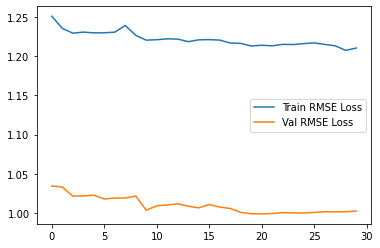

In [46]:
plt.plot(train_results["train_loss"], label="Train RMSE Loss")
plt.plot(train_results["val_loss"], label="Val RMSE Loss")
plt.legend()
plt.show()

## Evaluation

In [48]:
pred_dict = evaluate.evaluate(model=model, val_loader=val_loader)
preds = pred_dict["preds"]
true_energies = pred_dict["true_energies"]

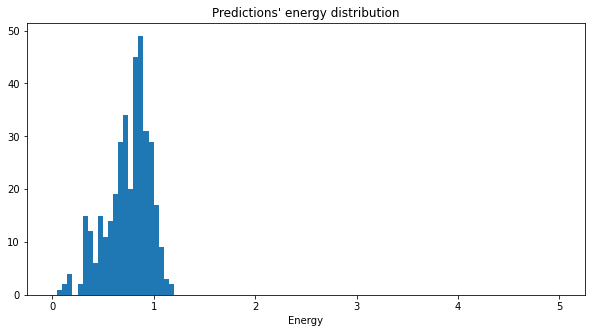

In [49]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

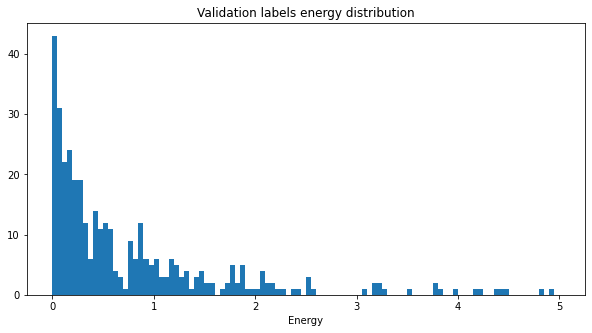

In [50]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [51]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.43331117587527235, Labels' std: 1.2233260234571641
MSE: 1.373
MAE: 0.692


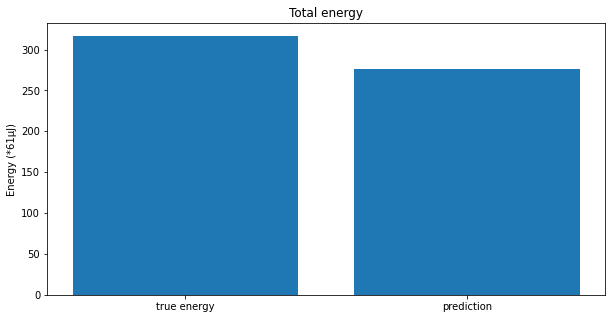

In [52]:
plt.figure(figsize=(10, 5))
plt.title("Total energy")
plt.ylabel("Energy (*61μJ)")
plt.bar(["true energy", "prediction"], [sum(true_energies), sum(preds)])
plt.show()

## Test programs prediction

In [53]:
test_embs = [emb.tolist() for emb in test_df.bb_embeddings.tolist()]
test_preds = evaluate.predict(model=model, test_bbs=test_embs)
true_energies = test_df.energy.values

In [54]:
median = np.median(true_energies)
std = np.std(true_energies)
mse = round(mean_squared_error(true_energies, test_preds), 3)
mae = round(mean_absolute_error(true_energies, test_preds), 3)

print(f"Labels' median: {median}, Labels' std: {std}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

Labels' median: 0.41797089442791097, Labels' std: 1.4697779148824242
MSE: 2.084
MAE: 0.831
